# Time Series Prediction with TensorFlow RNN

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import libraries: numpy pandas and matplotlib **

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

** Check out the head of the dataframe**

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
milk.index = pd.to_datetime(milk.index)

In [5]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Plot out the time series data. **

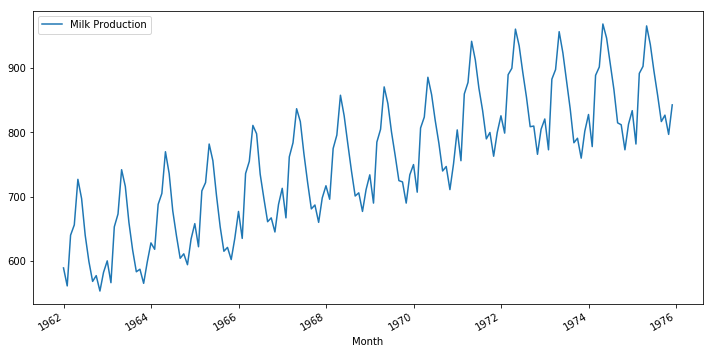

In [6]:
milk.plot(figsize=(12,6))

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** We don't want a random train test split, we want to specify that the test set is the last 3 months of data is the test set, with everything before it is the training. **

In [7]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [8]:
train_set = milk.head(156)

In [9]:
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. We shouldn't fit on the test data as well**

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
train_scaled = scaler.fit_transform(train_set)

In [13]:
test_scaled = scaler.transform(test_set)

## Batch Function

In [14]:
def next_batch(training_data,batch_size,steps):
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting Up The RNN Model

** Import TensorFlow **

In [21]:
import tensorflow as tf

### The Constants

* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.003)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [23]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.03 
starter_learning_rate = 0.1
# global_step = tf.Variable(0, trainable=False)
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            100000, 0.96, staircase=True)
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

** Create Placeholders for X and y.**  

In [17]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

** Now create the RNN Layer,  Other options: tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc...**

In [18]:
# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with our first placeholder (X)**

In [19]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in learning rate. **

In [25]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(loss)

** Initialize the global variables **

In [26]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [27]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by the next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save the model after you are done training. **

In [28]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [29]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.025721
100 	MSE: 0.0454939
200 	MSE: 0.0120033
300 	MSE: 0.0134895
400 	MSE: 0.00915576
500 	MSE: 0.00586875
600 	MSE: 0.00952985
700 	MSE: 0.00667365
800 	MSE: 0.00840582
900 	MSE: 0.0116498
1000 	MSE: 0.0076091
1100 	MSE: 0.0100037
1200 	MSE: 0.00543294
1300 	MSE: 0.00371118
1400 	MSE: 0.00615691
1500 	MSE: 0.0041688
1600 	MSE: 0.0199327
1700 	MSE: 0.00737524
1800 	MSE: 0.00442926
1900 	MSE: 0.00527581
2000 	MSE: 0.0071592
2100 	MSE: 0.00395707
2200 	MSE: 0.00587858
2300 	MSE: 0.00963576
2400 	MSE: 0.00572814
2500 	MSE: 0.00444031
2600 	MSE: 0.00260856
2700 	MSE: 0.00706393
2800 	MSE: 0.00939555
2900 	MSE: 0.00419569
3000 	MSE: 0.00654412
3100 	MSE: 0.00985013
3200 	MSE: 0.00293486
3300 	MSE: 0.00398104
3400 	MSE: 0.00527592
3500 	MSE: 0.0096338
3600 	MSE: 0.00416874
3700 	MSE: 0.00186529
3800 	MSE: 0.00606331
3900 	MSE: 0.0068015


______

## Predicting Future (Test Data)

** Our test_set (the last 12 months of your original complete data set) **

In [30]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session

Our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do!)


In [32]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for genreative seed from the last 12 months of the 
    # training set data.
    train_seed = list(train_scaled[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

In [33]:
train_seed

[array([ 0.66105769]),
 array([ 0.54086538]),
 array([ 0.80769231]),
 array([ 0.83894231]),
 array([ 1.]),
 array([ 0.94711538]),
 array([ 0.85336538]),
 array([ 0.75480769]),
 array([ 0.62980769]),
 array([ 0.62259615]),
 array([ 0.52884615]),
 array([ 0.625]),
 0.61399299,
 0.54961467,
 0.75713718,
 0.71923149,
 0.95203006,
 0.95463288,
 0.90793478,
 0.79792225,
 0.70162421,
 0.62485552,
 0.6054576,
 0.53861511]

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [34]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

In [38]:
test_set['Generated'] = results

/Users/zoha/.Envs/DS_BCamp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [39]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,808.421082
1975-02-01 01:00:00,782.0,781.639648
1975-03-01 01:00:00,892.0,867.969116
1975-04-01 01:00:00,903.0,852.200317
1975-05-01 01:00:00,966.0,949.044556
1975-06-01 01:00:00,937.0,950.127319
1975-07-01 01:00:00,896.0,930.700928
1975-08-01 01:00:00,858.0,884.935669
1975-09-01 01:00:00,817.0,844.875610


** Plot out the two columns for comparison. **

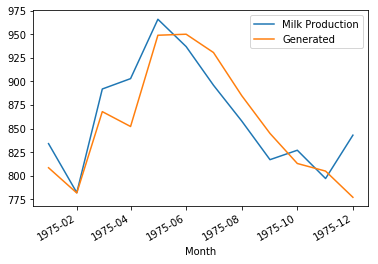

In [40]:
test_set.plot()

## Modifying the parameters to get a better fit

In [61]:
tf.reset_default_graph()


# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
# learning_rate = 0.03 

# global_step = tf.Variable(0, trainable=False)
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            100000, 0.96, staircase=True)
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

batch = tf.Variable(0)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(
  starter_learning_rate,                # Base learning rate.
  batch * batch_size,  # Current index into the dataset.
  num_train_iterations,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.elu),
    output_size=num_outputs) 

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [62]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

optimizer = tf.train.MomentumOptimizer(learning_rate,
                                     0.9)

train = optimizer.minimize(loss, global_step=batch)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.0290159
100 	MSE: 0.0211618
200 	MSE: 0.0125977
300 	MSE: 0.0131305
400 	MSE: 0.0111032
500 	MSE: 0.0125697
600 	MSE: 0.0124521
700 	MSE: 0.00792005
800 	MSE: 0.0132998
900 	MSE: 0.0125427
1000 	MSE: 0.0132737
1100 	MSE: 0.0127448
1200 	MSE: 0.00989182
1300 	MSE: 0.010833
1400 	MSE: 0.00708879
1500 	MSE: 0.00978799
1600 	MSE: 0.0130271
1700 	MSE: 0.00907143
1800 	MSE: 0.00834083
1900 	MSE: 0.0129276


In [63]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for genreative seed from the last 12 months of the 
    # training set data.
    train_seed = list(train_scaled[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


In [64]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [65]:
test_set['Generated'] = results

/Users/zoha/.Envs/DS_BCamp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


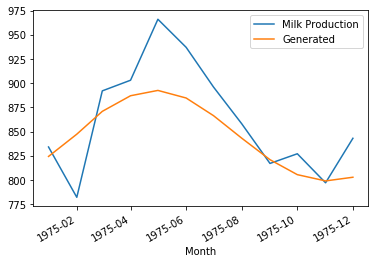

In [66]:
test_set.plot()